In [1]:
import cudf
import pandas as pd
import numpy as np
import time

/nvme/0/pgali/envs/cudfdev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 10_000_00, dtype='int64')
})

In [4]:
pdf

,numbers
0,-316
1,-441
2,653
3,216
4,-165
...,...
999995,309
999996,-748
999997,-615
999998,-590


In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
gdf

,numbers
0,-316
1,-441
2,653
3,216
4,-165
...,...
999995,309
999996,-748
999997,-615
999998,-590


In [7]:
def time_it(callable):
    start = time.time()
    callable()
    end = time.time()
    return end - start

In [8]:
start = time.time()
pdf.to_parquet("pandas.parquet")
end = time.time()

In [9]:
pandas_to_parquet = time_it(lambda : pdf.to_parquet("pandas.parquet"))

In [10]:
cudf_to_parquet = time_it(lambda : gdf.to_parquet("cudf.parquet"))

In [11]:
pandas_read_parquet = time_it(lambda : pd.read_parquet("pandas.parquet"))

In [12]:
cudf_read_parquet = time_it(lambda : cudf.read_parquet("cudf.parquet"))

In [13]:
pandas_to_csv = time_it(lambda : pdf.to_csv("pandas.csv"))

In [14]:
cudf_to_csv = time_it(lambda : gdf.to_csv("cudf.csv"))

In [15]:
pandas_read_csv = time_it(lambda : pd.read_csv("pandas.csv"))

In [16]:
cudf_read_csv = time_it(lambda : cudf.read_csv("cudf.csv"))

In [35]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 10_000_00, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=10_000_00)
})

In [36]:
pdf

,numbers,business
0,-454,Walmart
1,-31,McD
2,4,McD
3,-93,Costco
4,-862,Costco
...,...,...
999995,-495,McD
999996,-497,Costco
999997,470,Buckees
999998,-767,Walmart


In [37]:
pdf.groupby("business").agg(["min", "max", "mean"])

numbers               
             min  max      mean
business                       
Buckees    -1000  999  2.317219
Costco     -1000  999 -0.253886
McD        -1000  999 -0.575806
Walmart    -1000  999 -0.429581

In [38]:
print(time_it(lambda : pdf.groupby("business").agg(["min", "max", "mean"])))

0.06323885917663574


In [39]:
gdf = cudf.from_pandas(pdf)

In [40]:
print(time_it(lambda : gdf.groupby("business").agg(["min", "max", "mean"])))

0.007342338562011719


In [17]:
import matplotlib.pyplot as plt

In [18]:
perf_df = pd.DataFrame(
    {
        "perf": [pandas_to_parquet/cudf_to_parquet, pandas_read_parquet/cudf_read_parquet, pandas_to_csv/cudf_to_csv, pandas_read_csv/cudf_read_csv],
}, index=["to_parquet", "read_parquet", "to_csv", "read_csv"])

In [19]:
perf_df

,perf
to_parquet,0.972220
read_parquet,2.589605
to_csv,47.988225
read_csv,8.820821


[Text(0, 0, '0.97222'),
 Text(0, 0, '2.5896'),
 Text(0, 0, '47.9882'),
 Text(0, 0, '8.82082')]

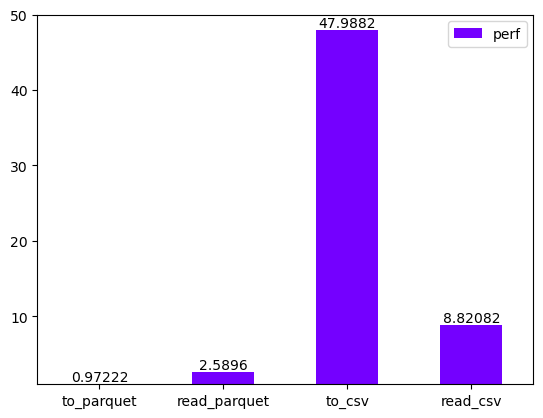

In [28]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,50), rot=0)
ax.bar_label(ax.containers[0])

AttributeError: 'AxesSubplot' object has no attribute 'show'